# **FOREWORD**

1. I start off with the competition data without any additional features
2. I train a number of ML models and TABPFNClassifier too
3. I collate their OOF predictions and Hill-Climb them to arrive at a solution blend
4. I use the best public kernel, akin to others and try and blend the results in step 3 with this kernel to check the LB score


### **COMPETITION DETAILS AND METRIC**

This kernel is for the Playground Season 5-Episode 3 competition with AUC score as the eval metric. <br>
This metric needs to be maximized and this is a **binary classifier** to predict the probability of rainfall, off a HongKong weather dataset.


My adjutant kernel [here](https://www.kaggle.com/code/ravi20076/playgrounds5e3-public-imports-v1) has all background scripts ready-to-use. I can't label this as AutoML, but at least this is a humble step in this regard. I shall load these scripts below, plug and play!

### **REFERENCES**
- https://www.kaggle.com/code/cdeotte/rapids-knn-starter-ensemble-lb-0-956-wow
- https://www.kaggle.com/code/act18l/lb-probing


In this version, I don't drop the day column as indicated in a comment in the previous kernel version. I also use Leave one year out CV scheme and test the impact!


# **IMPORTS**

In [1]:
%%time 

!pip install -q uv
!uv pip install -q --system -r /kaggle/input/playgrounds5e3-public-imports-v1/req_kaggle.txt

exec( open(f"/kaggle/input/playgrounds5e3-public-imports-v1/myimports.py", "r").read() )
exec( open(f"/kaggle/input/playgrounds5e3-public-imports-v1/myutils.py", "r").read() )
exec( open(f"/kaggle/input/playgrounds5e3-public-imports-v1/training.py", "r").read() )

print()

---> Sklearn = 1.6.1| Pandas = 2.2.3
---> Imports- part 1 done
---> Commencing imports-part2
---> XGBoost = 2.1.4 | LightGBM = 4.5.0
---> Imports- part 2 done
---> Seeding everything

---> Imports done


CPU times: user 13.9 s, sys: 2.13 s, total: 16 s
Wall time: 32.5 s


# **CONFIGURATION**

In [2]:
%%time

class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;

    # Data preparation:-
    version_nb  = 3
    model_id    = "V3_2"
    model_label = "ML"

    test_req           = False
    test_sample_frac   = 200

    gpu_switch         = "ON" if torch.cuda.is_available() else "OFF"
    state              = 42
    target             = f"rainfall"
    grouper            = f""
    tgt_mapper         = {}

    ip_path            = f"/kaggle/input/playground-series-s5e3"
    op_path            = f"/kaggle/working"
    orig_path          = f""
    data_path          = f""

    dtl_preproc_req    = False
    ftre_plots_req     = True
    ftre_imp_req       = True

    nb_orig            = 0
    orig_all_folds     = False

    # Model Training:-
    pstprcs_oof        = False
    pstprcs_train      = False
    pstprcs_test       = False
    ML                 = True
    test_preds_req     = True

    n_splits           = 6
    n_repeats          = 1
    nbrnd_erly_stp     = 0
    mdlcv_mthd         = 'SKF'
    metric_obj         = 'maximize'

    # Global variables for plotting:-
    grid_specs = {'visible'  : True,
                  'which'    : 'both',
                  'linestyle': '--',
                  'color'    : 'lightgrey',
                  'linewidth': 0.75
                 }

    title_specs = {'fontsize'   : 9,
                   'fontweight' : 'bold',
                   'color'      : '#992600',
                  }

collect()

CPU times: user 253 ms, sys: 881 µs, total: 254 ms
Wall time: 254 ms


0

# **PREPROCESSING**

We load the datasets and fix the CV-folds here <br>
We also impute the solitary null value in the test set column before proceding to model development

In [3]:
%%time 

train  = pd.read_csv(f"{CFG.ip_path}/train.csv", index_col = "id")
test   = pd.read_csv(f"{CFG.ip_path}/test.csv", index_col = "id")
sub_fl = pd.read_csv(f"{CFG.ip_path}/sample_submission.csv", index_col = "id")

PrintColor(f"---> Shapes = {train.shape} {test.shape} {sub_fl.shape}")

Xtrain = train.drop(CFG.target, axis=1)
ytrain = train[CFG.target].astype(np.uint8)
Xtest  = test.copy()
Xtest  = Xtest[Xtrain.columns]

Xtest["winddirection"] = Xtest["winddirection"].fillna( Xtest["winddirection"].ffill())
Xtrain["Source"], Xtest["Source"] = ("Competition" , "Competition")

PrintColor(f"---> Shapes = {Xtrain.shape} {Xtest.shape} {ytrain.shape}\n")

ygrp = pd.Series( Xtrain.index // 365, index = Xtrain.index, name = "year_nb", dtype = np.int8 )

cv    = LOGO()
folds = np.zeros( len(Xtrain) )

for fold_nb, (train_idx, dev_idx) in enumerate( cv.split(Xtrain, ytrain, ygrp) ):
    folds[dev_idx] = fold_nb

ygrp  = pd.Series(folds, index = train.index.values, name = "fold_nb", dtype = np.int8)

---> Shapes = (2190, 12) (730, 11) (730, 1)
---> Shapes = (2190, 12) (730, 12) (2190,)

CPU times: user 22.5 ms, sys: 5.52 ms, total: 28 ms
Wall time: 62 ms


# **MODEL TRAINING**

## **IO**

In [4]:
%%time 

Mdl_Master = \
{
    "LGBM1C" : LGBMC(
                    objective         = "binary",
                    eval_metric       = "auc",
                    n_estimators      = 400,
                    learning_rate     = 0.02,
                    max_depth         = 3,
                    colsample_bytree  = 0.95,
                    reg_alpha         = 0.001,
                    reg_lambda        = 0.001,
                    random_state      = CFG.state,
                    verbosity         = -1,
               ),

    "XGB1C" : XGBC(
                    objective         = "binary:logistic",
                    eval_metric       = "auc",
                    n_estimators      = 350,
                    learning_rate     = 0.02,
                    max_depth         = 3,
                    colsample_bytree  = 0.90,
                    colsample_bylevel = 0.80,
                    colsample_bynode  = 0.85,
                    reg_alpha         = 0.001,
                    reg_lambda        = 0.001,
                    random_state      = CFG.state,
                    verbosity         = 0,
                  ),

    "CB1C" : CBC(
                loss_function     = "Logloss",
                eval_metric       = "AUC",
                task_type         = "CPU",
                iterations        = 350,
                learning_rate     = 0.02,
                max_depth         = 3,
                colsample_bylevel = 0.90,
                random_state      = CFG.state,
                verbose           = 0,
                l2_leaf_reg       = 0.25,
                ),

    "HGB1C" : HGBC(
                    loss              = 'log_loss',
                    learning_rate     = 0.025,
                    max_iter          = 300,
                    max_depth         = 5,
                    l2_regularization = 0.40,
                    random_state      = CFG.state,
                  ),

    "RF1C"  : RFC(
                    n_estimators     = 250,
                    max_depth        = 5,
                    min_samples_leaf = 8,
                    random_state     = CFG.state,
                    verbose          = 0,
               ),

    "LR1C"  : LRC(C = 0.05, max_iter = 5_000, random_state = CFG.state),

    "KNN1C" : KNNC(n_neighbors = 125) ,
}

if CFG.gpu_switch == "ON" :
    Mdl_Master["TPFN1C"] = TPFNC(random_state = CFG.state, )
else:
    pass

OOF_Preds = {}
Mdl_Preds = {}
FtreImp   = {}
drop_cols = ["Source", "id", "Id", "Label", CFG.target, "fold_nb", ]


CPU times: user 610 µs, sys: 866 µs, total: 1.48 ms
Wall time: 3.89 ms


## **OFFLINE TRAINING**

  0%|          | 0/7 [00:00<?, ?it/s]



 ============== LGBM1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LGBM1C Fold0         OOF = 0.848219 | Train = 0.950119 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LGBM1C Fold1         OOF = 0.910222 | Train = 0.942396 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LGBM1C Fold2         OOF = 0.911448 | Train = 0.939549 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LGBM1C Fold3         OOF = 0.894662 | Train = 0.946789 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LGBM1C Fold4         OOF = 0.886501 | Train = 0.944574 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LGBM1C Fold5         OOF = 0.883052 | Train = 0.943747 




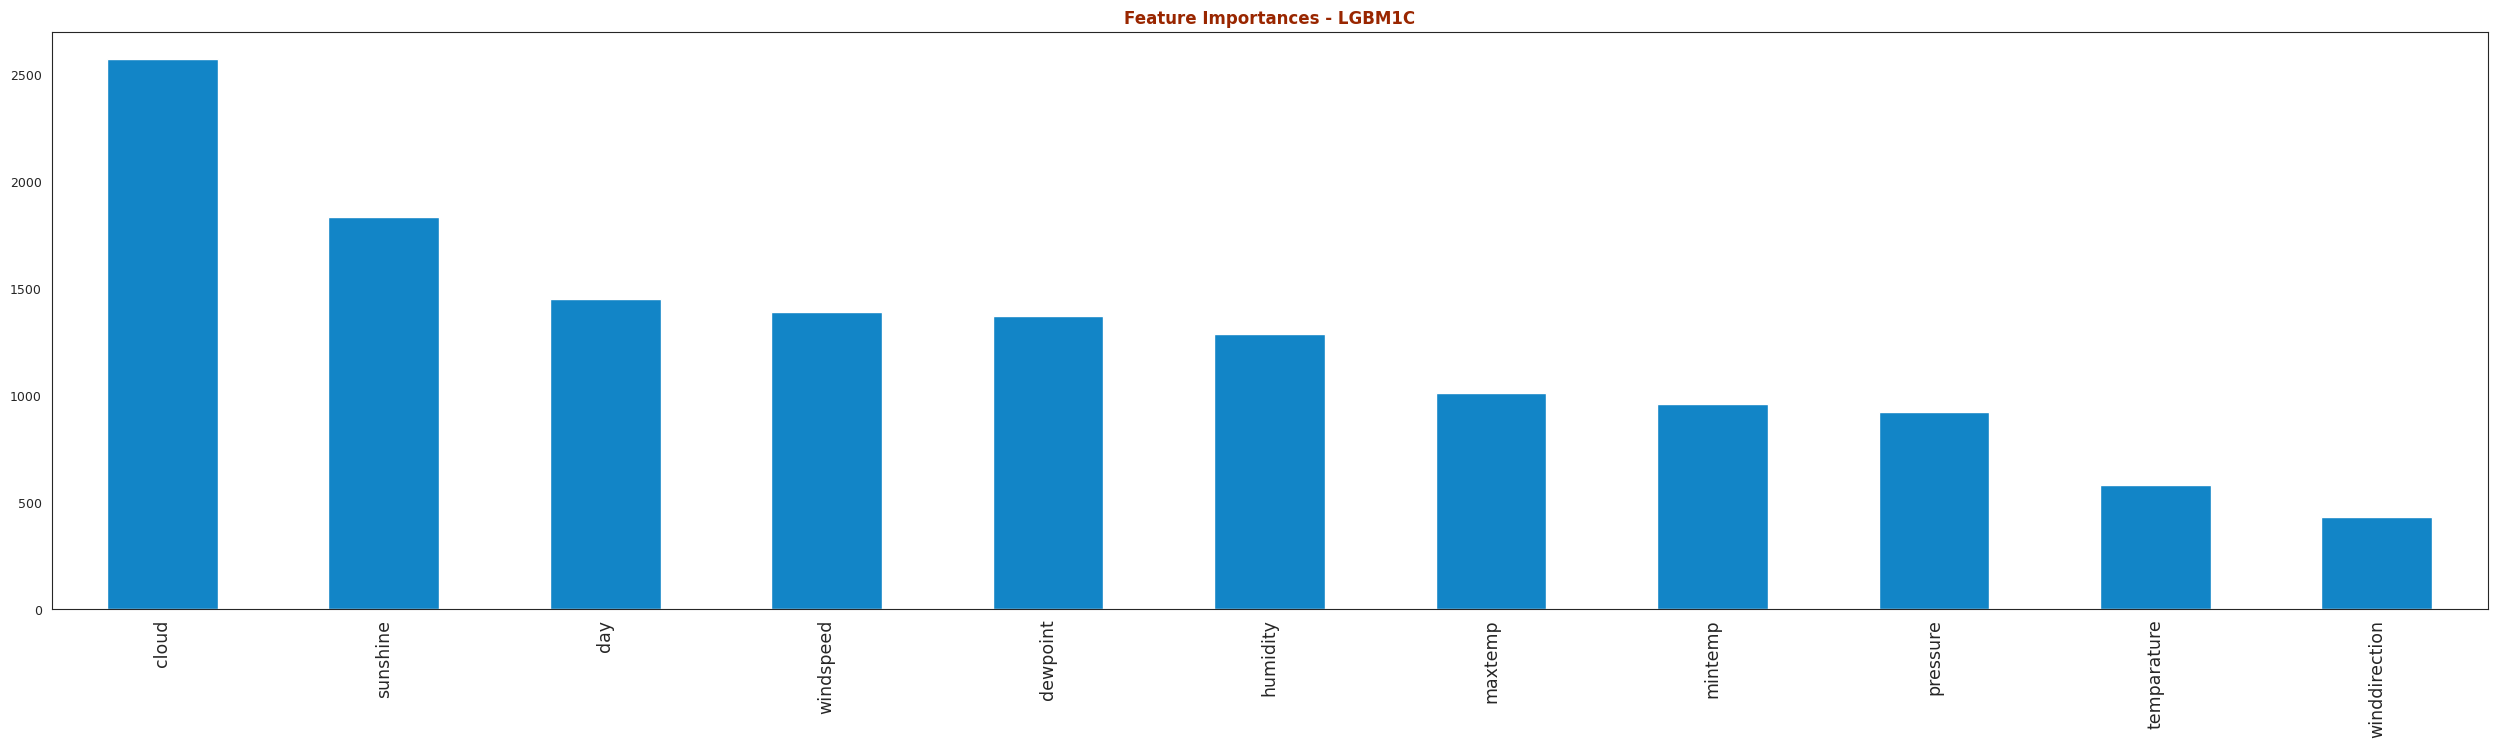



---> 0.889017 +- 0.021178 | OOF
---> 0.944529 +- 0.003325 | Train


 ============== XGB1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
XGB1C Fold0          OOF = 0.848333 | Train = 0.947140 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
XGB1C Fold1          OOF = 0.912444 | Train = 0.937935 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
XGB1C Fold2          OOF = 0.917694 | Train = 0.937862 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
XGB1C Fold3          OOF = 0.896607 | Train = 0.943335 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
XGB1C Fold4          OOF = 0.886623 | Train = 0.939936 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
XGB1C Fold5          OOF = 0.884526 | Train = 0.942426 




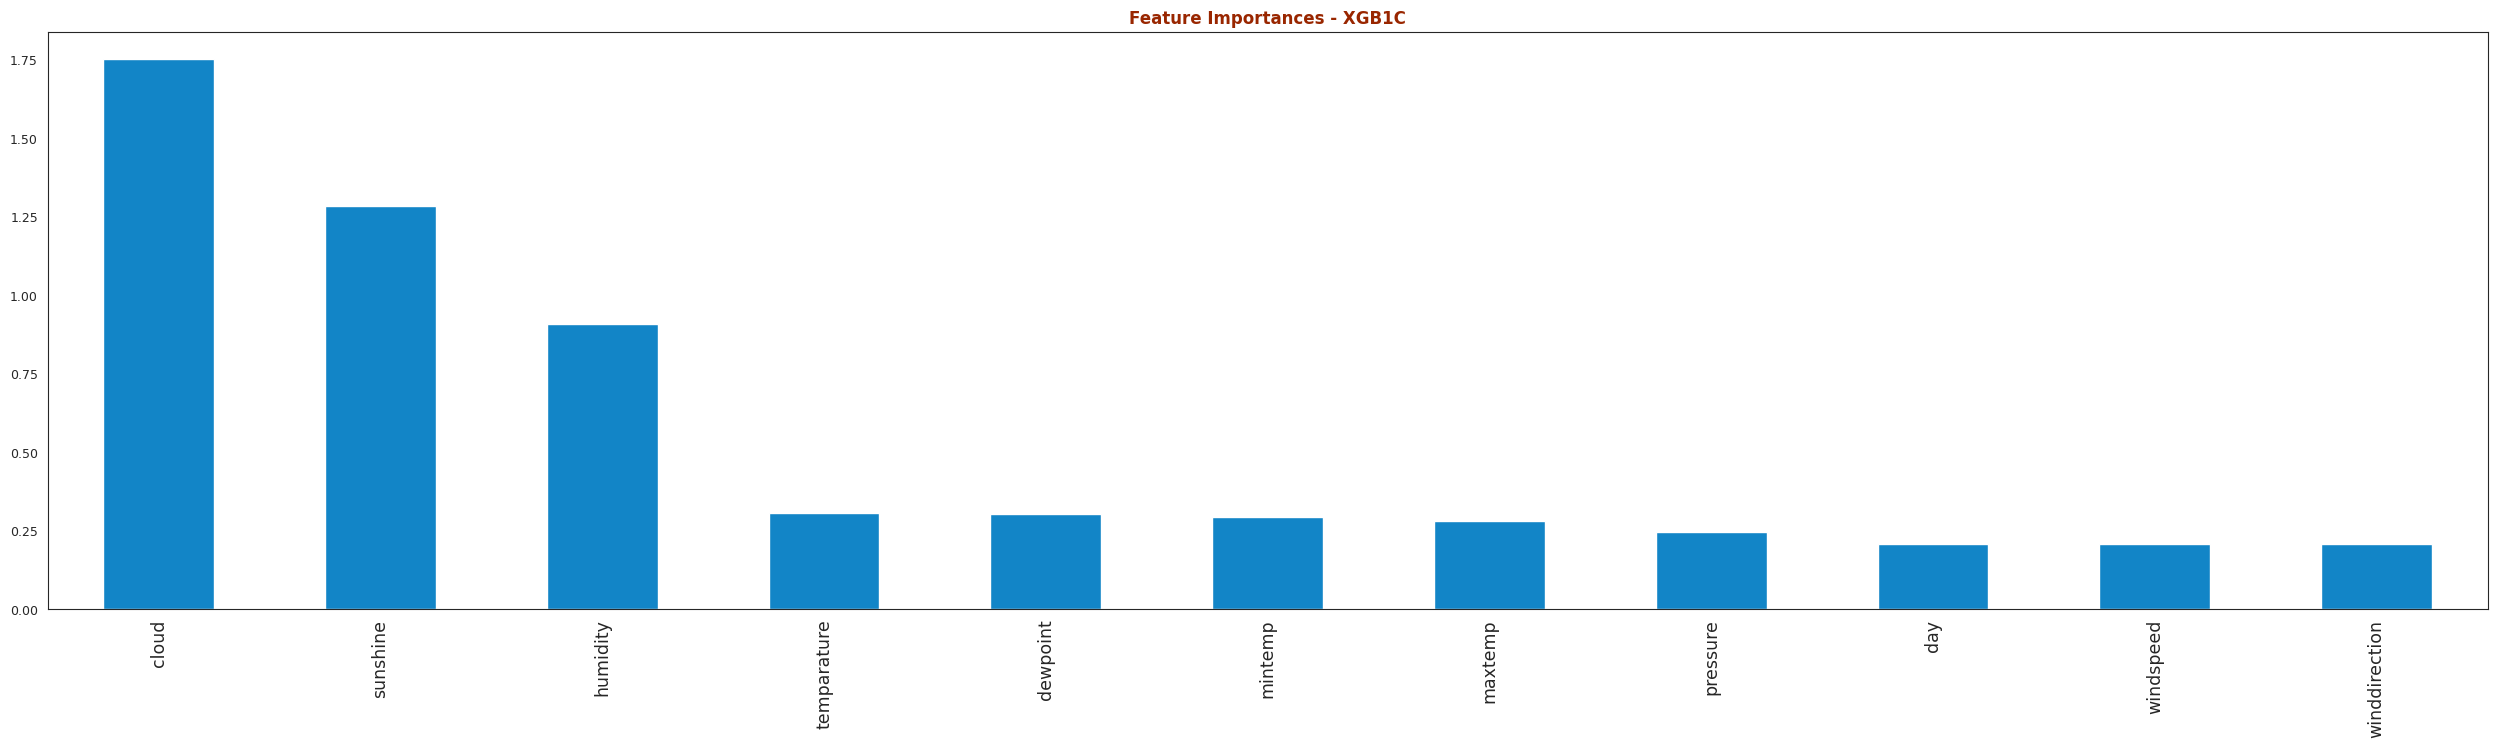



---> 0.891038 +- 0.022677 | OOF
---> 0.941439 +- 0.003276 | Train


 ============== CB1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
CB1C Fold0           OOF = 0.856649 | Train = 0.928742 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
CB1C Fold1           OOF = 0.917293 | Train = 0.919974 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
CB1C Fold2           OOF = 0.920620 | Train = 0.918460 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
CB1C Fold3           OOF = 0.894321 | Train = 0.921639 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
CB1C Fold4           OOF = 0.885239 | Train = 0.921719 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
CB1C Fold5           OOF = 0.879478 | Train = 0.924273 




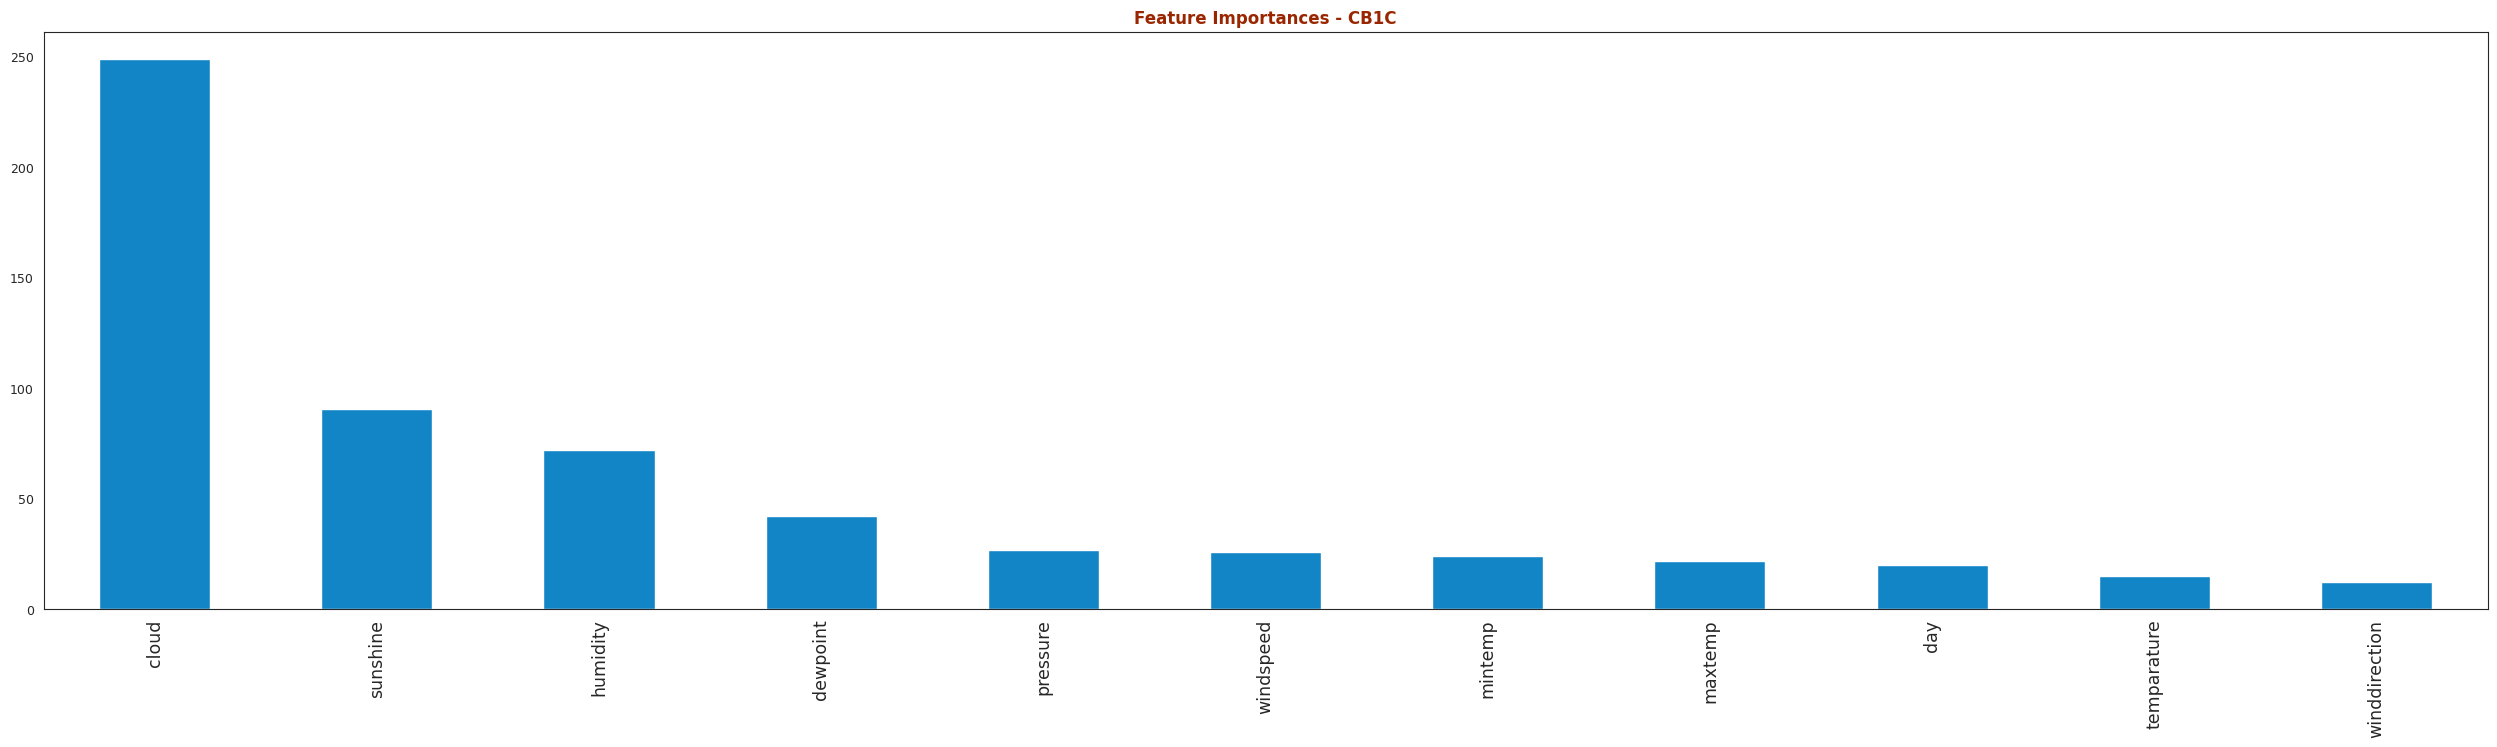



---> 0.892267 +- 0.022045 | OOF
---> 0.922468 +- 0.003320 | Train


 ============== HGB1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
HGB1C Fold0          OOF = 0.839637 | Train = 0.984725 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
HGB1C Fold1          OOF = 0.905697 | Train = 0.975693 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
HGB1C Fold2          OOF = 0.912674 | Train = 0.977474 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
HGB1C Fold3          OOF = 0.898933 | Train = 0.976471 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
HGB1C Fold4          OOF = 0.879132 | Train = 0.978216 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
HGB1C Fold5          OOF = 0.880327 | Train = 0.978568 




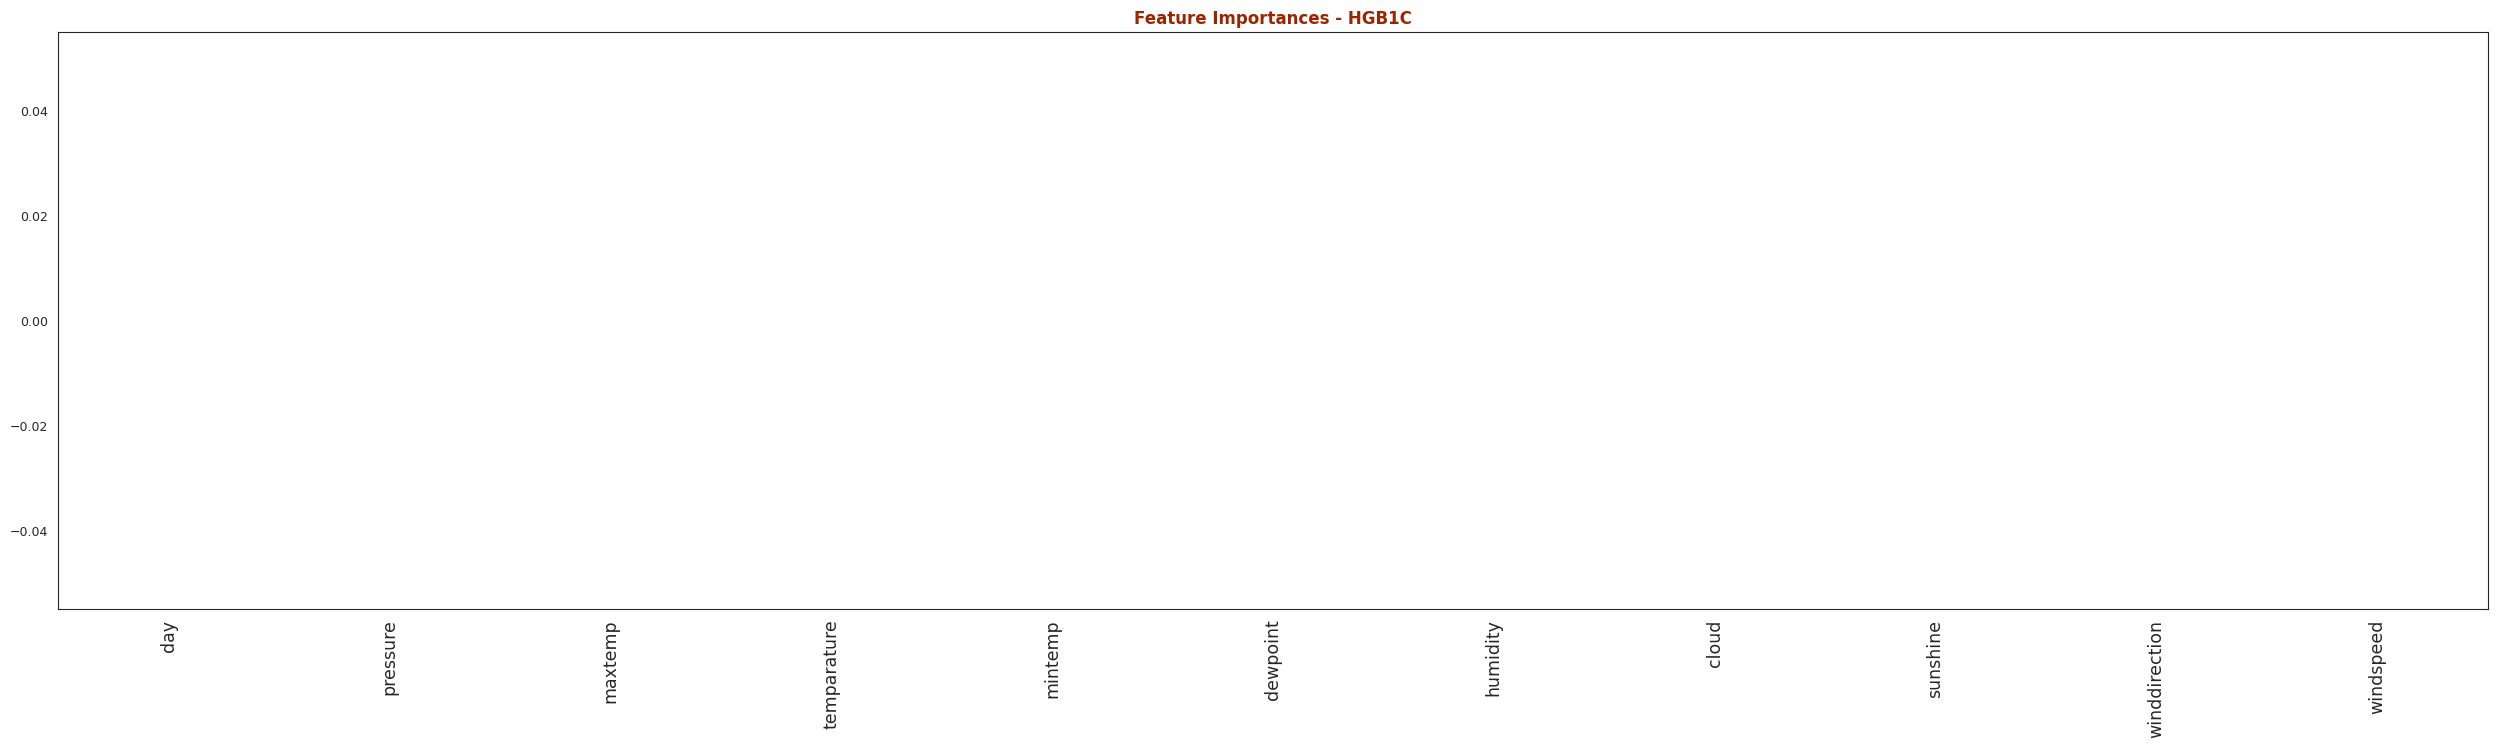



---> 0.886067 +- 0.024137 | OOF
---> 0.978524 +- 0.002941 | Train


 ============== RF1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
RF1C Fold0           OOF = 0.858662 | Train = 0.933764 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
RF1C Fold1           OOF = 0.910626 | Train = 0.925343 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
RF1C Fold2           OOF = 0.921371 | Train = 0.924720 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
RF1C Fold3           OOF = 0.901700 | Train = 0.927193 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
RF1C Fold4           OOF = 0.872700 | Train = 0.927136 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
RF1C Fold5           OOF = 0.875726 | Train = 0.928689 




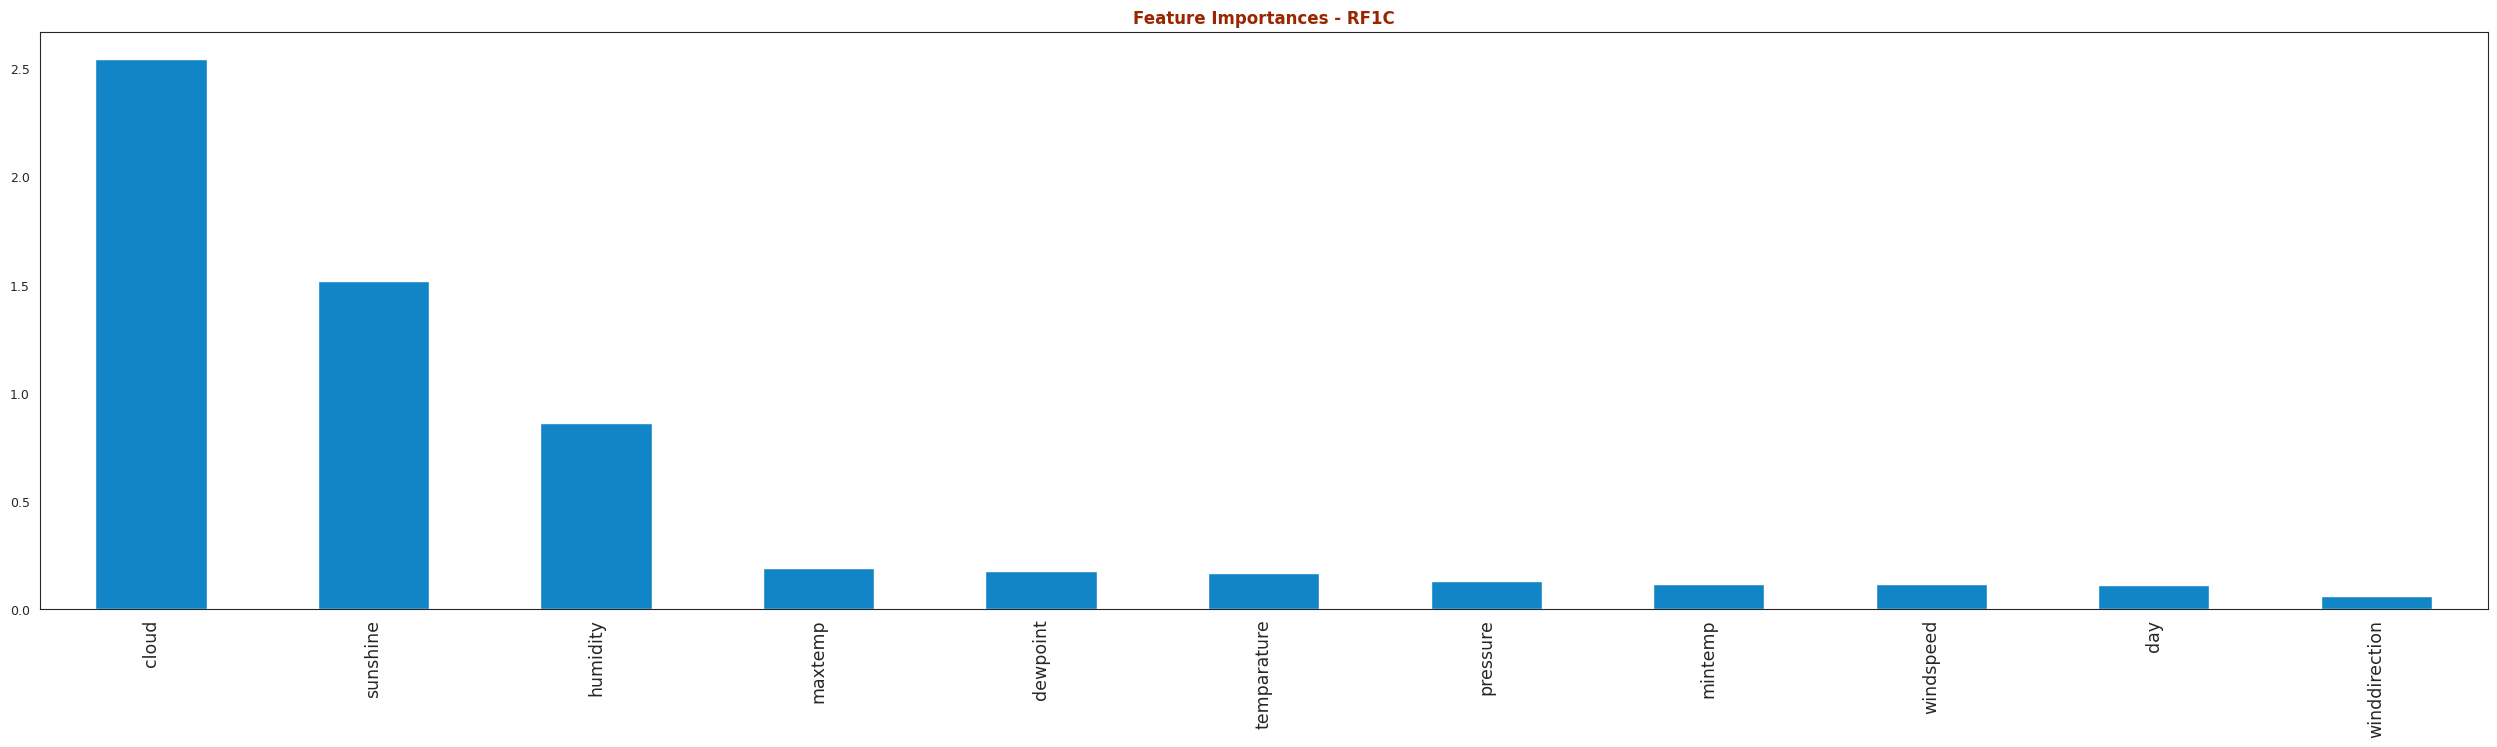



---> 0.890131 +- 0.022478 | OOF
---> 0.927807 +- 0.002963 | Train


 ============== LR1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LR1C Fold0           OOF = 0.858358 | Train = 0.904302 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LR1C Fold1           OOF = 0.912081 | Train = 0.892688 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LR1C Fold2           OOF = 0.918485 | Train = 0.892291 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LR1C Fold3           OOF = 0.900658 | Train = 0.895574 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LR1C Fold4           OOF = 0.885890 | Train = 0.898088 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
LR1C Fold5           OOF = 0.886224 | Train = 0.897881 




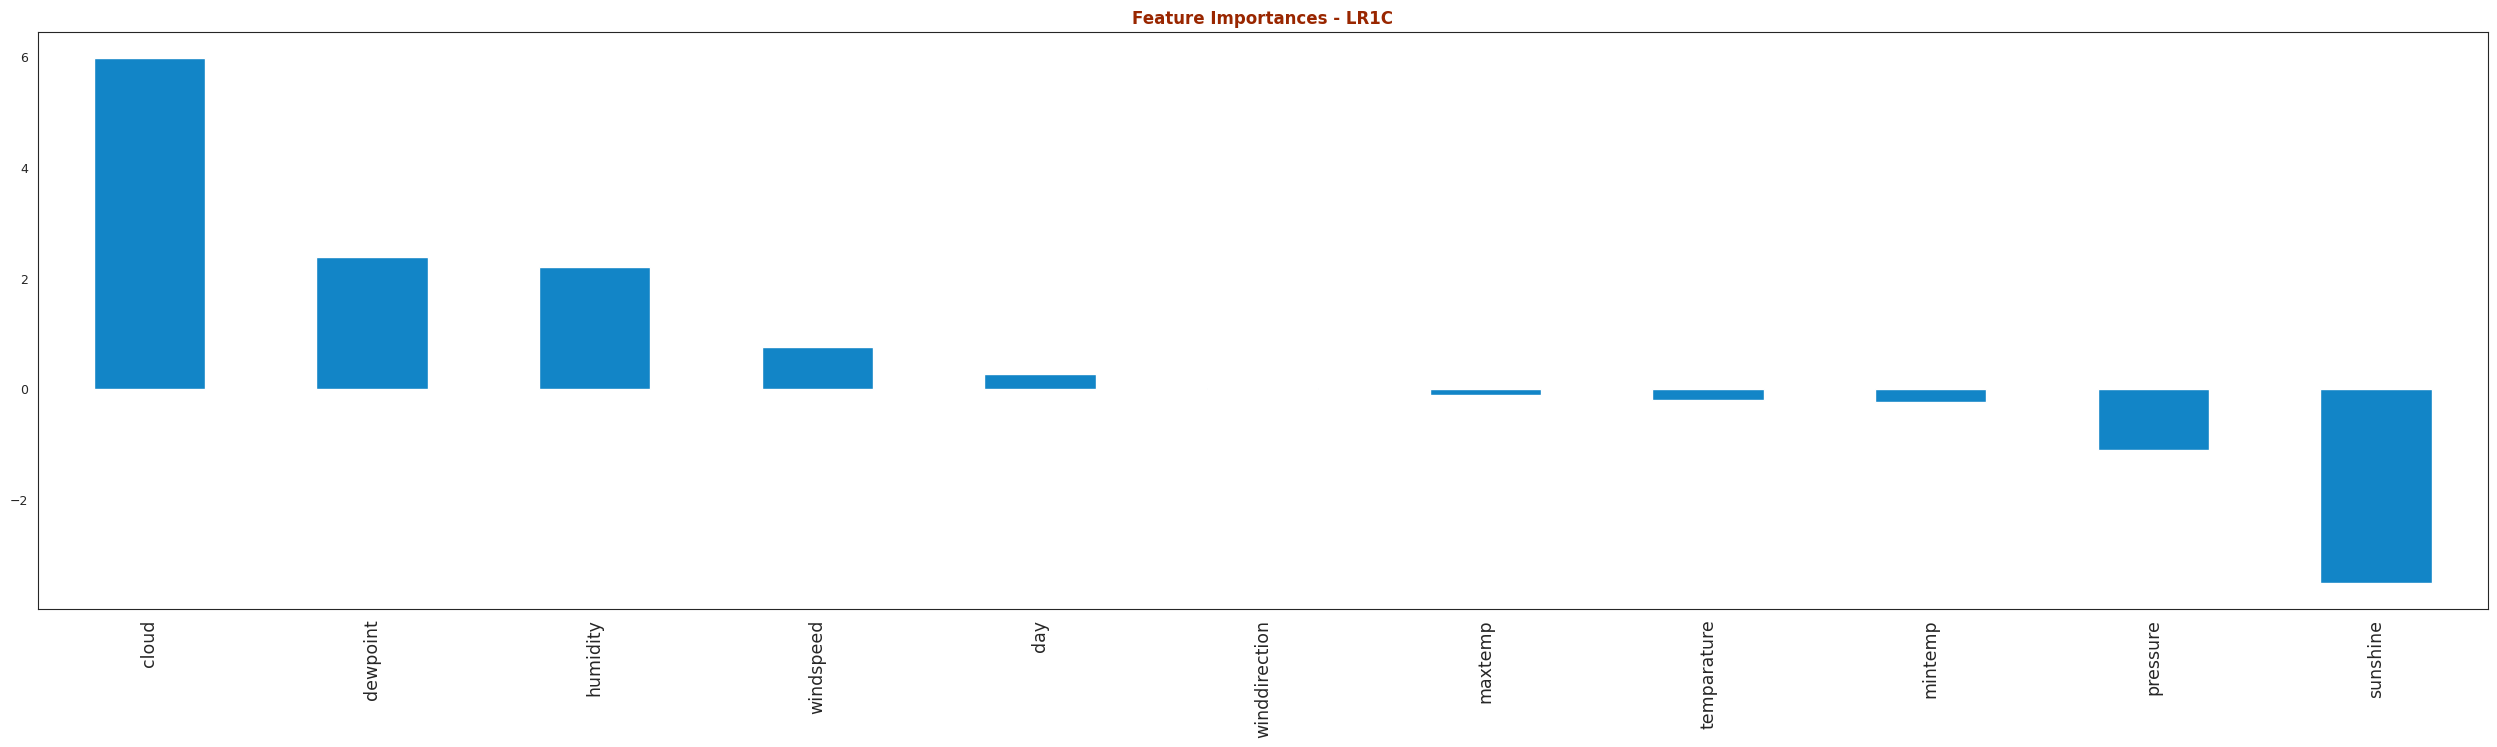



---> 0.893616 +- 0.019860 | OOF
---> 0.896804 +- 0.004038 | Train


 ============== KNN1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
KNN1C Fold0          OOF = 0.831814 | Train = 0.901972 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
KNN1C Fold1          OOF = 0.905596 | Train = 0.885522 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
KNN1C Fold2          OOF = 0.917042 | Train = 0.884991 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
KNN1C Fold3          OOF = 0.900979 | Train = 0.886811 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
KNN1C Fold4          OOF = 0.869606 | Train = 0.892844 

---> Shapes = (1825, 11) (1825,) -- (365, 11) (365,) -- (730, 11)
KNN1C Fold5          OOF = 0.882203 | Train = 0.891573 




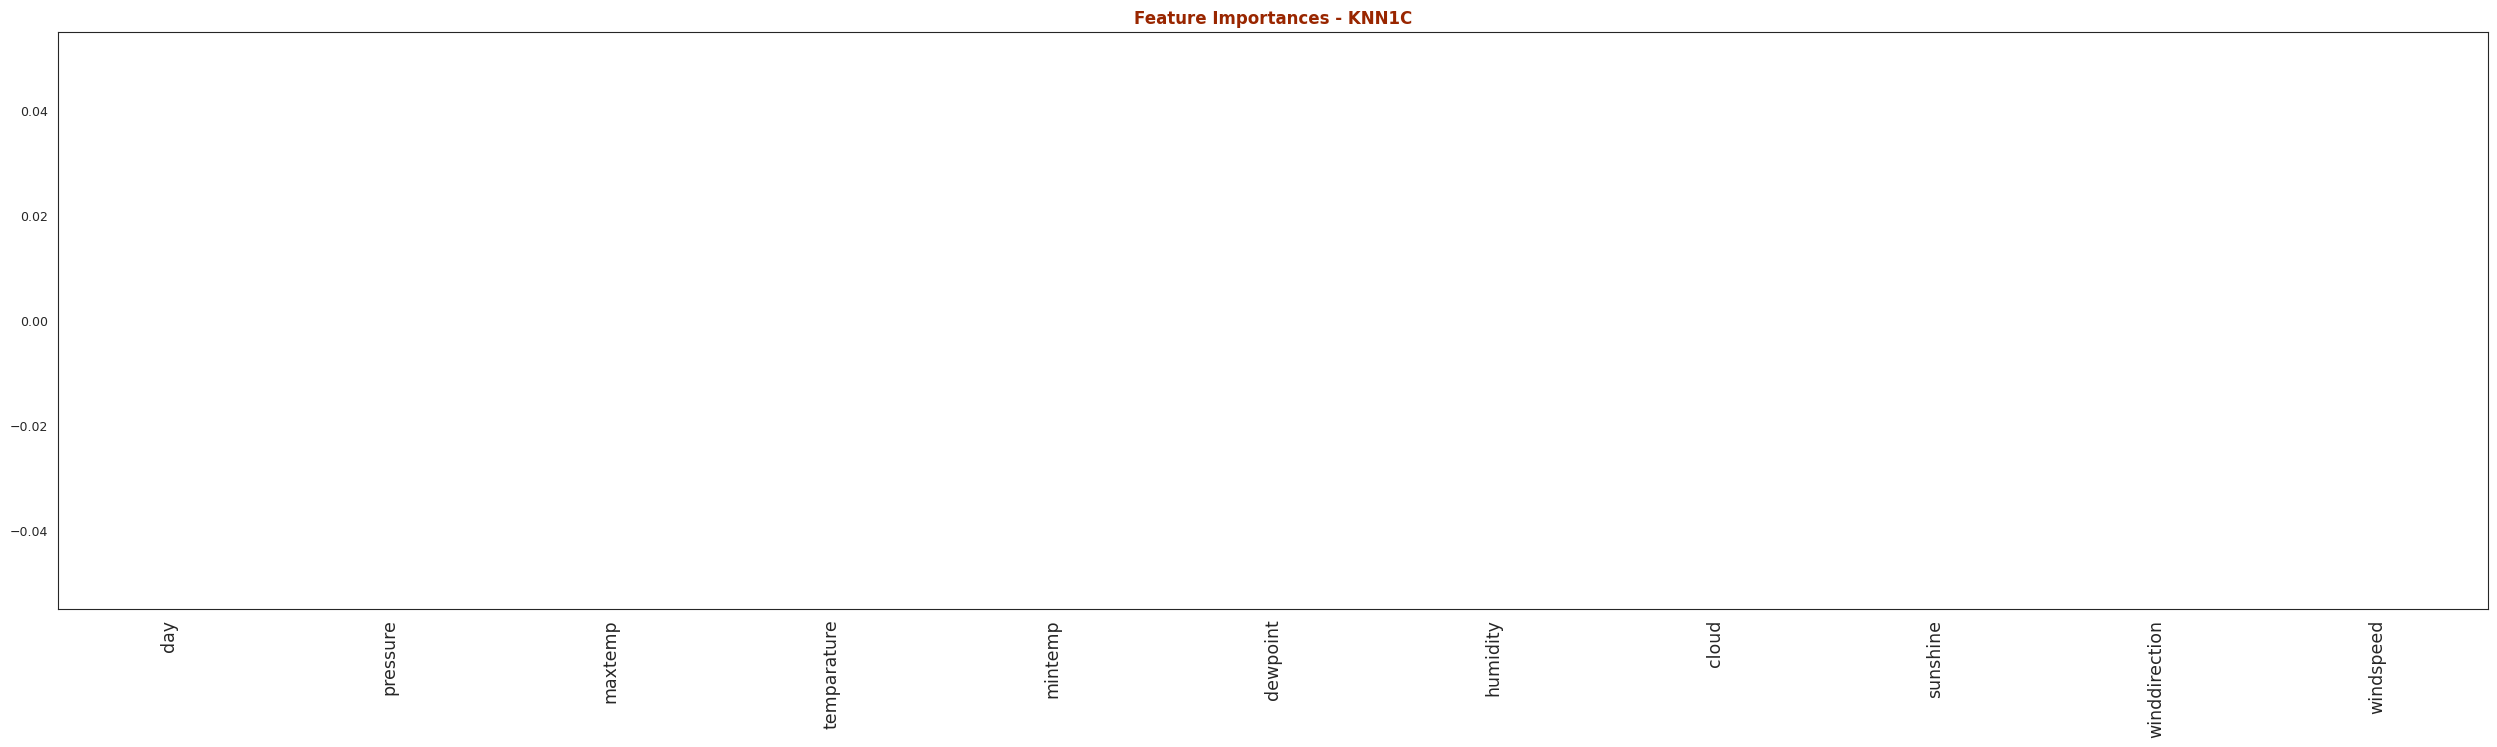



---> 0.884540 +- 0.028221 | OOF
---> 0.890619 +- 0.005872 | Train

CPU times: user 34.3 s, sys: 3.84 s, total: 38.1 s
Wall time: 23.3 s


In [5]:
%%time 

for method, model in tqdm( Mdl_Master.items() ) :

    PrintColor(
        f"\n\n ============== {method} MODEL TRAINING ============== \n\n",
        color = Fore.RED
    )

    md = \
    ModelTrainer(
        problem_type   = "binary",
        es             = CFG.nbrnd_erly_stp,
        target         = CFG.target,
        orig_req       = False,
        orig_all_folds = CFG.orig_all_folds,
        metric_lbl     = "auc",
        drop_cols      = drop_cols,
        pp_preds       = CFG.pstprcs_oof,
    )

    mymodel = Pipeline([("SS", StandardScaler()), ("M", model)])

    _, oof_preds, test_preds, ftreimp, _ =  \
    md.MakeOfflineModel(
        Xtrain,
        ytrain,
        ygrp,
        Xtest,
        clone( mymodel ),
        method,
        test_preds_req   = CFG.test_preds_req,
        ftreimp_plot_req = CFG.ftre_plots_req,
        ntop = 50,
    )

    OOF_Preds[method] = oof_preds
    Mdl_Preds[method] = test_preds
    FtreImp[method]   = ftreimp

    collect()

_ = utils.CleanMemory()
print();

# **ENSEMBLE**

We use a hill-climber blending strategy in-fold to blend the predictions

In [6]:
%%time 

ens_oof_preds = np.zeros( len(Xtrain))
ens_mdl_preds = 0
cv = PDS(ygrp)

oof_preds = pd.DataFrame(OOF_Preds)
mdl_preds = pd.DataFrame(Mdl_Preds)

for fold_nb, (train_idx, dev_idx) in enumerate( cv.split( oof_preds, ytrain) ):
    
    hc = HillClimber()
    dev_preds, preds, _ = \
    hc.DoHillClimb(
        target    = CFG.target, 
        direction = CFG.metric_obj, 
        cutoff    = 100, 
        neg_wgt   = "Y",
        OOF_Preds = oof_preds.iloc[dev_idx],
        Mdl_Preds = mdl_preds.copy() ,
        y         = ytrain.iloc[dev_idx],
    )

    ens_oof_preds[dev_idx] = dev_preds
    ens_mdl_preds += ( preds / CFG.n_splits )

score = utils.ScoreMetric( ytrain.values.flatten(), ens_oof_preds)
PrintColor(
    f"\n---> Ensemble OOF score = {score:,.8f} \n", 
    color = Fore.RED
)

print()
_ = utils.CleanMemory()


----- Data preparation: ------ 



,RF1C,LR1C,CB1C,XGB1C,LGBM1C,HGB1C,KNN1C
Score,0.85866,0.85836,0.85665,0.84833,0.84822,0.83964,0.83181



 ----- Initiating hill-climb ----- 

 1.RF1C                                                Weight =  0.5000       Score = 0.854637
 2.LR1C                                                Weight =  0.5000       Score = 0.857674
 3.KNN1C                                               Weight = -0.5000       Score = 0.861700
 4.XGB1C                                               Weight = -0.5000       Score = 0.865497
 5.CB1C                                                Weight = -0.1000       Score = 0.865915
 6.HGB1C                                               Weight =  0.0100       Score = 0.865953

----- Data preparation: ------ 



,CB1C,XGB1C,LR1C,RF1C,LGBM1C,HGB1C,KNN1C
Score,0.91729,0.91244,0.91208,0.91063,0.91022,0.90570,0.90560



 ----- Initiating hill-climb ----- 

 1.CB1C                                                Weight =  0.5000       Score = 0.915758
 2.KNN1C                                               Weight =  0.2100       Score = 0.916848
 3.RF1C                                                Weight = -0.0600       Score = 0.917051
 4.LR1C                                                Weight = -0.0100       Score = 0.917131

----- Data preparation: ------ 



,RF1C,CB1C,LR1C,XGB1C,KNN1C,HGB1C,LGBM1C
Score,0.92137,0.92062,0.91849,0.91769,0.91704,0.91267,0.91145



 ----- Initiating hill-climb ----- 

 1.RF1C                                                Weight =  0.4900       Score = 0.919276
 2.KNN1C                                               Weight =  0.4400       Score = 0.921569
 3.CB1C                                                Weight =  0.3000       Score = 0.921648
 4.XGB1C                                               Weight = -0.2000       Score = 0.922122
 5.HGB1C                                               Weight =  0.0100       Score = 0.922201

----- Data preparation: ------ 



,RF1C,KNN1C,LR1C,HGB1C,XGB1C,LGBM1C,CB1C
Score,0.90170,0.90098,0.90066,0.89893,0.89661,0.89466,0.89432



 ----- Initiating hill-climb ----- 

 1.KNN1C                                               Weight =  0.5000       Score = 0.902864
 2.CB1C                                                Weight = -0.4000       Score = 0.904267
 3.RF1C                                                Weight =  0.1800       Score = 0.904829
 4.XGB1C                                               Weight = -0.3400       Score = 0.905390
 5.HGB1C                                               Weight =  0.1700       Score = 0.906433

----- Data preparation: ------ 



,XGB1C,LGBM1C,LR1C,CB1C,HGB1C,RF1C,KNN1C
Score,0.88662,0.88650,0.88589,0.88524,0.87913,0.87270,0.86961



 ----- Initiating hill-climb ----- 

 1.LR1C                                                Weight =  0.0600       Score = 0.887193
 2.HGB1C                                               Weight = -0.0100       Score = 0.887315

----- Data preparation: ------ 



,LR1C,XGB1C,LGBM1C,KNN1C,HGB1C,CB1C,RF1C
Score,0.88622,0.88453,0.88305,0.88220,0.88033,0.87948,0.87573



 ----- Initiating hill-climb ----- 

 1.LR1C                                                Weight =  0.4600       Score = 0.886804
 2.RF1C                                                Weight = -0.5000       Score = 0.890423
 3.CB1C                                                Weight = -0.4400       Score = 0.891807
 4.XGB1C                                               Weight =  0.1900       Score = 0.891986
 5.KNN1C                                               Weight =  0.0100       Score = 0.892254

---> Ensemble OOF score = 0.89492031 


CPU times: user 29.6 s, sys: 60.9 ms, total: 29.6 s
Wall time: 29.7 s


# **SUBMISSION**

In [7]:
%%time 

sub = \
pd.read_csv(
    f"/kaggle/input/rapids-knn-starter-ensemble-lb-0-956-wow/submission_ensemble.csv"
)[CFG.target].values.flatten()


scl = MinMaxScaler((0, 100))
sub_fl[CFG.target] = \
np.average(
    scl.fit_transform( np.stack([ens_mdl_preds, sub], axis=1) ),
    axis=1,
    weights = [-0.2, 1.2]
)

sub_fl.to_csv("submission.csv", index = True)

oof_preds.index.name = "id"
mdl_preds.index.name = "id"
(
    oof_preds.
    assign(**{"Ensemble" : ens_oof_preds}).
    to_csv(
        f"{CFG.op_path}/OOF_Preds_{CFG.model_label}{CFG.model_id}.csv"
    )
)

(
    mdl_preds.
    assign(**{"Ensemble" : ens_mdl_preds}).
    to_csv(
        f"{CFG.op_path}/Mdl_Preds_{CFG.model_label}{CFG.model_id}.csv"
    )
)

print()
!ls
print()
!head submission.csv
del sub
print()


catboost_info	      __notebook__.ipynb    submission.csv
Mdl_Preds_MLV3_2.csv  OOF_Preds_MLV3_2.csv  xgb_optimize.log

id,rainfall
2190,99.74027292395472
2191,99.50617283950615
2192,100.93768312160887
2193,11.77004426599558
2194,5.373006010082538
2195,76.8936736013057
2196,84.44235182776399
2197,99.60591008718283
2198,95.74778136619862

CPU times: user 57.5 ms, sys: 42.2 ms, total: 99.7 ms
Wall time: 354 ms
